In [1]:
%matplotlib inline
from casatasks import tclean, ft, clearcal, uvsub, split
from casatools import ms, table, msmetadata
from spectral_cube import SpectralCube
import spectral_cube
import numpy as np
from astropy import units as u, visualization
from astropy.visualization import simple_norm
import pylab as pl

import warnings
import spectral_cube
warnings.simplefilter('ignore', spectral_cube.utils.BeamWarning)
warnings.simplefilter('ignore', spectral_cube.utils.StokesWarning)
warnings.simplefilter('ignore', spectral_cube.utils.PossiblySlowWarning)

visualization.quantity_support()
ms = ms()
msmd = msmetadata()
tb = table()

In [2]:
pl.rcParams['font.size'] = 14
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
pl.rcParams['figure.facecolor'] = 'w'

From the casa docs:
"alpha = taylorcoeff_1 / taylorcoeff_0"

In [3]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L


In [4]:
ls -d imaging_results/W43-MM3_B[36]*_continuum_merged_12M_robust0_selfcal*_finaliter*.image.tt0

imaging_results/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0/
imaging_results/W43-MM3_B6_uid___A001_X1296_X129_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0/


In [27]:
finaliter_prefix = "imaging_results/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter"

In [28]:
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image')
image.wcs.wcs.crval

array([ 2.81922750e+02, -2.00766664e+00,  9.85681209e+10])

Text(0.5, 1.0, 'model.tt1')

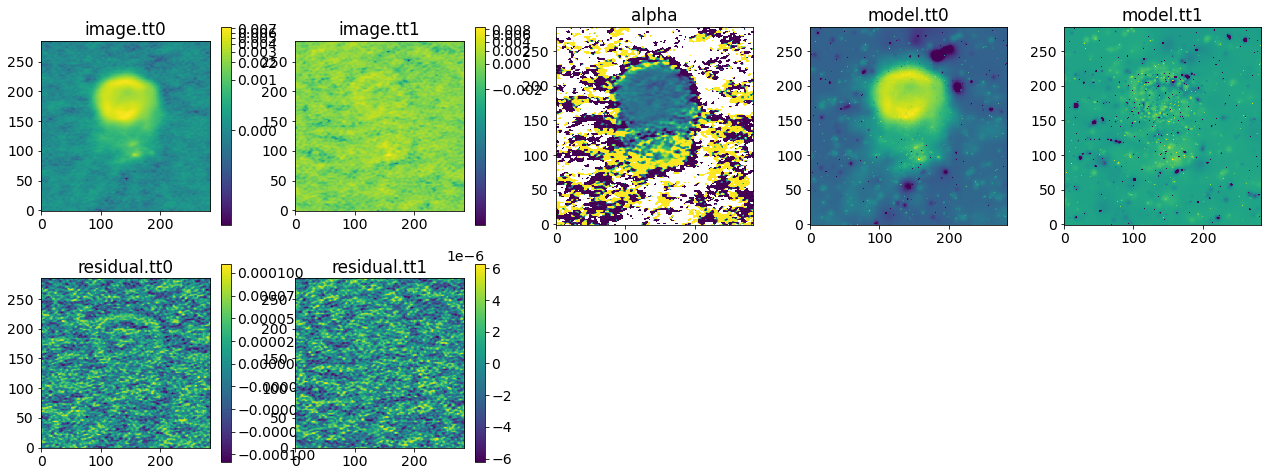

In [29]:
cutoutregion = 'fk5; box(281.9241, -2.007, 20", 20")'
pl.figure(figsize=(22,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,1).imshow(image[0].value, norm=simple_norm(image[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt0")
imagett1 = SpectralCube.read(f'{finaliter_prefix}.image.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,2).imshow(imagett1[0].value, norm=simple_norm(imagett1[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt1")
residual = SpectralCube.read(f'{finaliter_prefix}.residual.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,6).imshow(residual[0].value, norm=simple_norm(residual[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt0")
residualtt1 = SpectralCube.read(f'{finaliter_prefix}.residual.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,7).imshow(residualtt1[0].value, norm=simple_norm(residualtt1[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt1")
alpha = SpectralCube.read(f'{finaliter_prefix}.alpha', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,3).imshow(alpha[0].value, norm=simple_norm(alpha[0].value, stretch='linear', min_cut=-2, max_cut=4));
pl.title("alpha")
model = SpectralCube.read(f'{finaliter_prefix}.model.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,4).imshow(model[0].value, norm=simple_norm(model[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt0")
modeltt1 = SpectralCube.read(f'{finaliter_prefix}.model.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,5).imshow(modeltt1[0].value, norm=simple_norm(modeltt1[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt1")

In [30]:
tt0_std = image.mad_std()
tt1_std = imagett1.mad_std()
mask = (image > 5*tt0_std)# & (imagett1 > tt1_std)
imagem = image.with_mask(mask)
imagett1m = imagett1.with_mask(mask)
alpha = imagett1m / imagem

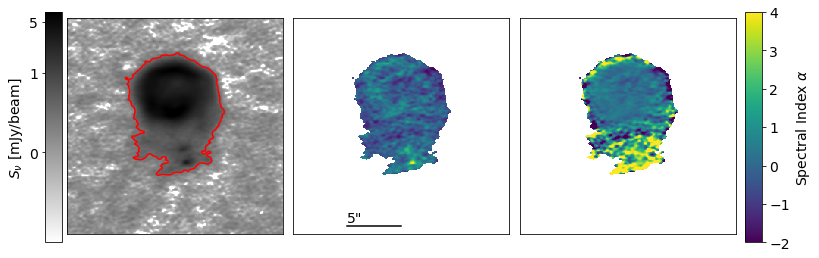

In [31]:
tt0_std = image.mad_std()
tt1_std = imagett1.mad_std()
mask = (image > 3*tt0_std) #& (imagett1 > tt1_std)
imagem = image.with_mask(mask)
imagett1m = imagett1.with_mask(mask)
alpha = imagett1m / imagem
fig = pl.figure(figsize=(12,4))
ax = pl.subplot(1,3,1); ax.imshow(image[0].value*1e3, cmap='gray_r', norm=simple_norm(image[0].value*1e3, stretch='log', min_percent=2, max_percent=99.9));
ax.contour(image[0].value, levels=[3*tt0_std.value], colors=['r']); ax.set_xticks([]); ax.set_yticks([]);
cb=pl.colorbar(mappable=pl.gca().images[0], cax=fig.add_axes([0.1,0.1,0.02,0.8]))
cb.ax.yaxis.set_ticks_position('left')
cb.set_ticks([0,1,5,10,20])
cb.set_label("$S_\\nu$ [mJy/beam]")
cb.ax.yaxis.set_label_position('left')
ax = pl.subplot(1,3,2); ax.imshow(imagett1m[0].value); ax.set_xticks([]); ax.set_yticks([]);
cd = (image.wcs.pixel_scale_matrix[1,1] * 3600)
ax.plot([70,70+5/cd], [10,10], color='k')
ax.annotate('5"', (70, 15),)
ax = pl.subplot(1,3,3); ax.imshow(alpha[0].value, vmax=4, vmin=-2); ax.set_xticks([]); ax.set_yticks([]);
cb=pl.colorbar(mappable=pl.gca().images[0], cax=fig.add_axes([0.91,0.1,0.02,0.8]))
cb.set_label(r"Spectral Index $\alpha$")
pl.subplots_adjust(wspace=0.05)
pl.savefig("paper_figures/W43MM3_B3_spectral_index.pdf", bbox_inches='tight')

In [32]:
finaliter_prefix = "imaging_results/W43-MM3_B6_uid___A001_X1296_X129_continuum_merged_12M_robust0_selfcal5_finaliter"

Text(0.5, 1.0, 'model.tt1')

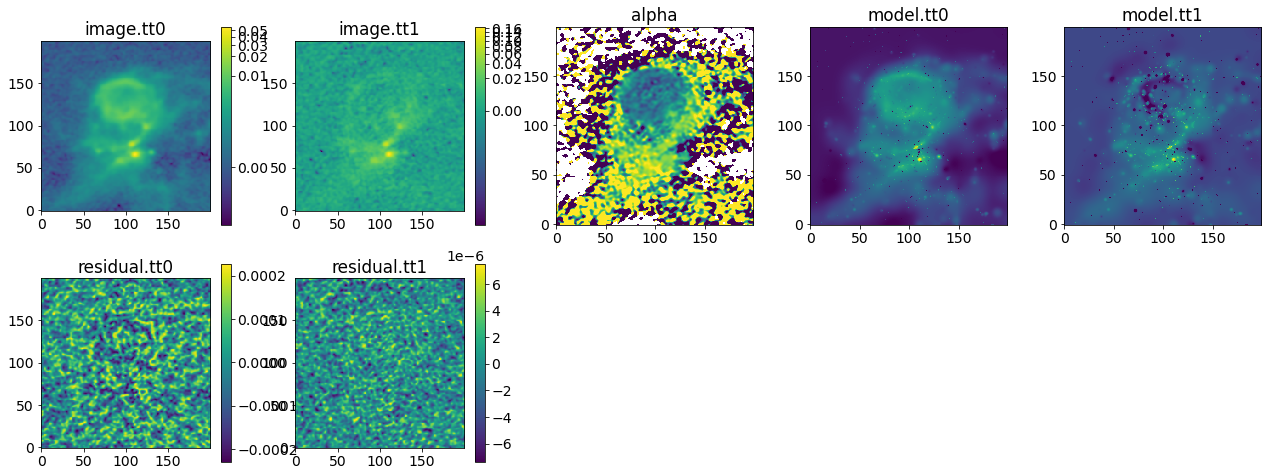

In [33]:
#cutoutregion = 'fk5; box(272.620167, -19.93008, 30",30")'
pl.figure(figsize=(22,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,1).imshow(image[0].value, norm=simple_norm(image[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt0")
imagett1 = SpectralCube.read(f'{finaliter_prefix}.image.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,2).imshow(imagett1[0].value, norm=simple_norm(imagett1[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt1")
residual = SpectralCube.read(f'{finaliter_prefix}.residual.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,6).imshow(residual[0].value, norm=simple_norm(residual[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt0")
residualtt1 = SpectralCube.read(f'{finaliter_prefix}.residual.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,7).imshow(residualtt1[0].value, norm=simple_norm(residualtt1[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt1")
alpha = SpectralCube.read(f'{finaliter_prefix}.alpha', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,3).imshow(alpha[0].value, norm=simple_norm(alpha[0].value, stretch='linear', min_cut=-2, max_cut=4));
pl.title("alpha")
model = SpectralCube.read(f'{finaliter_prefix}.model.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,4).imshow(model[0].value, norm=simple_norm(model[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt0")
modeltt1 = SpectralCube.read(f'{finaliter_prefix}.model.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,5).imshow(modeltt1[0].value, norm=simple_norm(modeltt1[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt1")

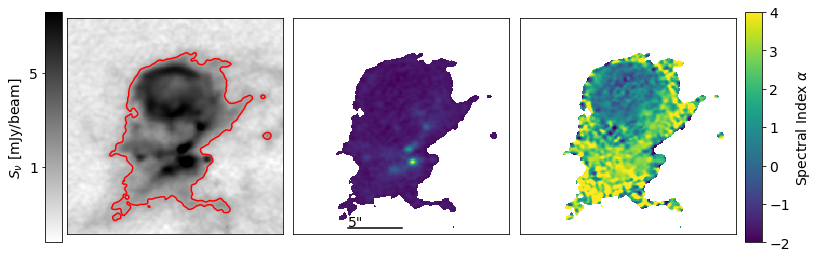

In [34]:
tt0_std = image.mad_std()
tt1_std = imagett1.mad_std()
mask = (image > 2*tt0_std) #& (imagett1 > tt1_std)
imagem = image.with_mask(mask)
imagett1m = imagett1.with_mask(mask)
alpha = imagett1m / imagem
fig = pl.figure(figsize=(12,4))
ax = pl.subplot(1,3,1); ax.imshow(image[0].value*1e3, cmap='gray_r', norm=simple_norm(image[0].value*1e3, stretch='asinh', min_percent=0, max_percent=99.5));
ax.contour(image[0].value, levels=[2*tt0_std.value], colors=['r']); ax.set_xticks([]); ax.set_yticks([]);
cb=pl.colorbar(mappable=pl.gca().images[0], cax=fig.add_axes([0.1,0.1,0.02,0.8]))
cb.ax.yaxis.set_ticks_position('left')
cb.set_ticks([1,5,20,50,100, 200, 500,])
cb.set_label("$S_\\nu$ [mJy/beam]")
cb.ax.yaxis.set_label_position('left')
ax = pl.subplot(1,3,2); ax.imshow(imagett1m[0].value); ax.set_xticks([]); ax.set_yticks([]);
cd = (image.wcs.pixel_scale_matrix[1,1] * 3600)
ax.plot([50,50+5/cd], [5,5], color='k')
ax.annotate('5"', (50, 7),)
ax = pl.subplot(1,3,3); ax.imshow(alpha[0].value, vmax=4, vmin=-2); ax.set_xticks([]); ax.set_yticks([]);
cb=pl.colorbar(mappable=pl.gca().images[0], cax=fig.add_axes([0.91,0.1,0.02,0.8]))
cb.set_label(r"Spectral Index $\alpha$")
pl.subplots_adjust(wspace=0.05)
pl.savefig("paper_figures/W43MM3_B6_spectral_index.pdf", bbox_inches='tight')